# Image Pixelization / De-Pixelization Demo

## 1. Load Original Image

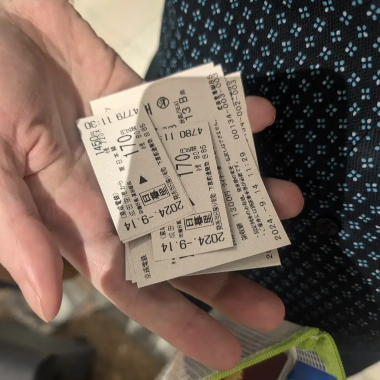

In [4]:
from PIL import Image
import torchvision.transforms.functional as TF

original = TF.to_tensor(Image.open('template.png').convert('RGBA')).unsqueeze_(0)

H, W = original.size()[-2:]

TF.to_pil_image(original[0])

## 2. Generate a Motion for the Pixelation

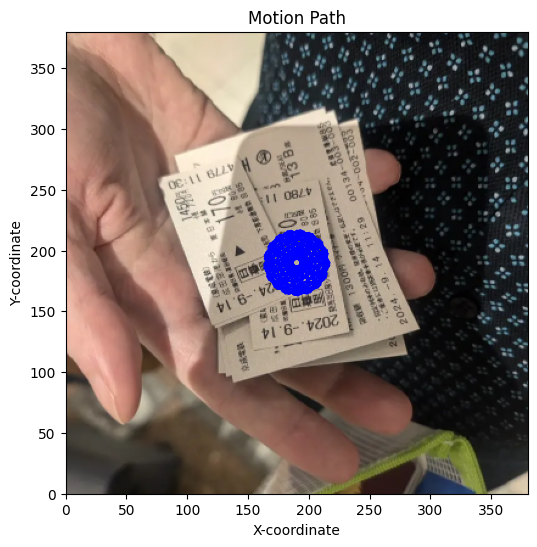

In [ ]:
import math

CHUNK_SIZE = 16
NUM_FRAMES = 250
AREA_SIZE = min(W, H) // 2 // CHUNK_SIZE * CHUNK_SIZE

# generate the motion of the pixelation
motion = []
for i in range(NUM_FRAMES):
    motion.append((
        W / 2 + math.cos(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.cos(i) * CHUNK_SIZE,
        H / 2 + math.sin(i / NUM_FRAMES * math.pi * 2) * AREA_SIZE / CHUNK_SIZE + math.sin(i) * CHUNK_SIZE
    ))

# display the path
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(TF.to_pil_image(TF.vflip(original[0])))
plt.plot(
    [m[0] for m in motion],
    [m[1] for m in motion],
    linestyle='-',
    color='b'
)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Motion Path")
plt.xlim(0, W)
plt.ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [9]:
import torch
import torch.nn.functional as F

frames = torch.zeros((NUM_FRAMES, 4, H, W))
frames[:] = original

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frames[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ] = F.interpolate(original[
        ...,
        y_start:y_end:CHUNK_SIZE,
        x_start:x_end:CHUNK_SIZE
    ], size=(AREA_SIZE, AREA_SIZE), mode='nearest')

def display_frames(frames):
    fig, ax = plt.subplots()
    ims = []
    for frame in frames:
        # Assuming 'frame[0]' is your image data that can be processed by TF.to_pil_image
        pil_image = TF.to_pil_image(TF.vflip(frame))
        # Append the image object returned by imshow to the list
        im_artist = ax.imshow(pil_image, animated=True)
        ims.append([im_artist]) # ims should be a list of lists of artists

    import matplotlib.animation as animation
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title("Pixelated")
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.gca().set_aspect('equal', adjustable='box')

    res =  ani.to_html5_video()
    plt.close()

    return res

from IPython.display import HTML
HTML(display_frames(frames))

## 2. Collect all Pixels and put them at their global position 

this is of course just a best case secenario, extracting the motion would be very easy.
in this case we will just reuse the motion, we used to generate the pixelation.

In [15]:
frame_pixels = torch.zeros((NUM_FRAMES, 4, H, W))

for i, (shift_x, shift_y) in enumerate(motion):
    x_start = round(shift_x - AREA_SIZE / 2)
    x_end = x_start + AREA_SIZE
    y_start = round(shift_y - AREA_SIZE / 2)
    y_end = y_start + AREA_SIZE
    frame_pixels[
        i:i+1, ...,
        y_start:y_end:CHUNK_SIZE,
        x_start:x_end:CHUNK_SIZE
    ] = F.interpolate(frames[
        i:i+1,
        ...,
        y_start:y_end,
        x_start:x_end
    ], size=(AREA_SIZE // CHUNK_SIZE, AREA_SIZE // CHUNK_SIZE), mode='area')

HTML(display_frames(frame_pixels))

## 3. Accumulate Pixels into Single Frame

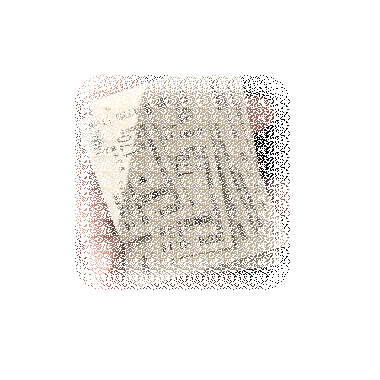

In [16]:
frame_accumulated = frame_pixels.sum(0, keepdim=True)
frame_accumulated = frame_accumulated / frame_accumulated[:,-1:]
frame_accumulated[~torch.isfinite(frame_accumulated)] = 0.0

TF.to_pil_image(frame_accumulated[0])

## 4. Grow the Pixels

this is just to make the result more readable

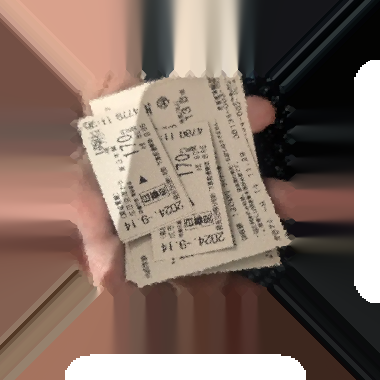

In [19]:
frame_growed = frame_accumulated.clone()
run = True
while run:
  c = frame_growed[:, -1:] == 0
  run = torch.any(c)
  x = F.avg_pool2d(frame_growed, 3, 1, 1, False, False, 1)
  c = c & torch.any(c)
  frame_growed += c.float() * x

frame_growed = frame_growed / frame_growed[:,-1:]
frame_growed[~torch.isfinite(frame_growed)] = 0.0

TF.to_pil_image(frame_growed[0])